<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_8_Making_Transformers_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making Transformers Efficient

*   knowledge distillation
*   quantization
*   pruning
*   graph optimization with the Open Neural Network Exchange (ONNX) format and ONNX Runtime (ORT).
*   Text Classification (CLINC150)
*   Creating a custom Trainer
*   Finding Good Hyperparameters with Optuna

The final models: 
* https://huggingface.co/GV05/distilbert-base-uncased-finetuned-clinc

* https://huggingface.co/GV05/distilbert-base-uncased-distilled-clinc

 


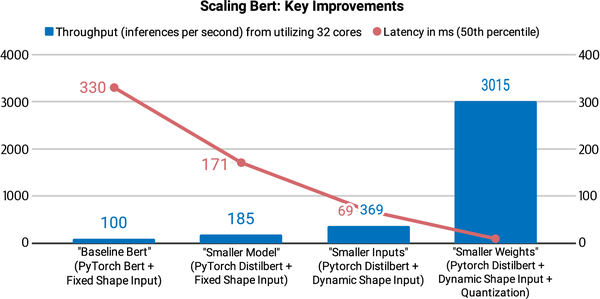

# Intent Detection as a Case Study

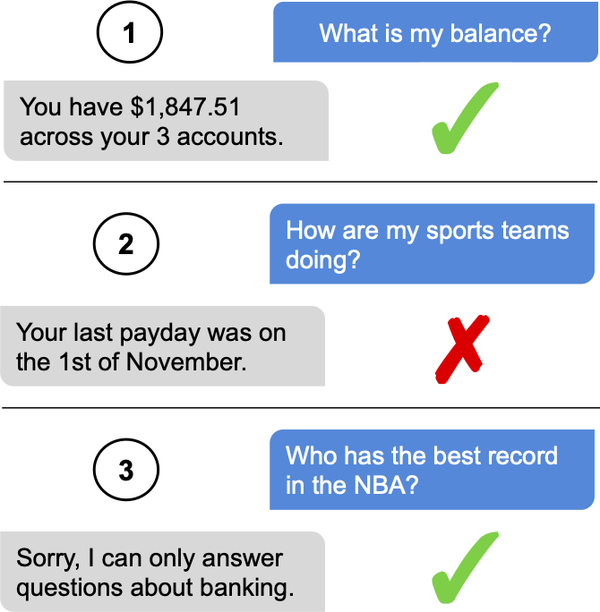

In [ ]:
!pip install -U onnx
!pip -q install onnxruntime
!pip install -q transformers[sentencepiece] datasets evaluate

In [3]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [2]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""

In [20]:
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

# Creating a Performance Benchmark

* Model performance
* Latency - How fast can our model deliver predictions
* Memory

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

CLINC150 dataset. 
This dataset includes 22,500 in-scope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 out-of-scope queries that belong to an oos intent class.

In [5]:
# test set
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus") # Here, the plus configuration refers to the subset that contains the out-of-scope training examples.

  0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [27]:
clinc["test"].features

{'text': Value(dtype='string', id=None),
 'intent': ClassLabel(names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined', 'rewards_balance', 'change_accent', 'vaccines', 'reminder_update', 'food_last', 'change_ai_name', 'bill_due', 'who_do_you_work_for', 'share_locat

In [28]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [6]:
# from datasets import load_metric
# accuracy_score = load_metric("accuracy")
import evaluate
accuracy_score = evaluate.load("accuracy")

In [7]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

**Next, let’s compute the size** of our model by using the torch.save() function from PyTorch to serialize the model to disk. Under the hood, torch.save() uses Python’s pickle module and can be used to save anything from models to tensors to ordinary Python objects. In PyTorch, the recommended way to save a model is by using its state_dict, which is a Python dictionary that maps each layer in a model to its learnable parameters (i.e., weights and biases). Let’s see what is stored in the state_dict of our baseline model:

In [27]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [28]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

we can then use the Path.stat() function from Python’s pathlib module to get information about the underlying files. In particular, Path(​"model.​pt").​stat().​st_size will give us the model size in bytes. Let’s put this all together in the com⁠pute_​size() function and add it to PerformanceBenchmark:

In [9]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

**Finally let’s implement the time_pipeline()** function so that we can time the average latency per query. 

For this application, latency refers to the time it takes to feed a text query to the pipeline and return the predicted intent from the model. 

Under the hood the pipeline also tokenizes the text, but this is around one thousand times faster than generating the predictions and thus adds a negligible contribution to the overall latency.

 A simple way to measure the execution time of a code snippet is to use the **perf_counter()** function from Python’s time module. 
 
 This function has a better time resolution than the time.time() function and is well suited for getting precise results.

In [10]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 166.746
Latency (ms) - 124.225
Latency (ms) - 133.763


In [31]:
a = perf_counter()
b = perf_counter()
a,b, b-a

(1108.146100034, 1108.146121226, 2.1192000076553086e-05)

In [11]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [34]:
# base model scores.

pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

# 5500 samples * 72.43 ms  ~  6.5 minuets

Model size (MB) - 418.15
Average latency (ms) - 82.61 +\- 16.36
Accuracy on test set - 0.867


In [35]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1508378982544,
  'time_avg_ms': 82.61263666998957,
  'time_std_ms': 16.36317076431462,
  'accuracy': 0.8672727272727273}}

# Making Models Smaller via Knowledge Distillation

## Knowledge Distillation for Fine-Tuning

Knowledge distillation is a general-purpose method for training a smaller student model to mimic the behavior of a slower, larger, but better-performing teacher.

**For supervised tasks like fine-tuning, the main idea is to augment the ground truth labels with a distribution of “soft probabilities” from the teacher.**

Mathematically, the way this works is as follows. Suppose we feed an input sequence x to the teacher to generate a vector of logits 𝐳(x) = [z1(x),...,zN(x)]. We can convert these logits into probabilities by applying a softmax function:

This isn’t quite what we want, though, because in many cases the teacher will assign a high probability to one class, with all other class probabilities close to zero. 

When that happens, the teacher doesn’t provide much additional information beyond the ground truth labels, so instead we “soften” the probabilities by scaling the logits with a temperature hyperparameter T before applying the softmax.

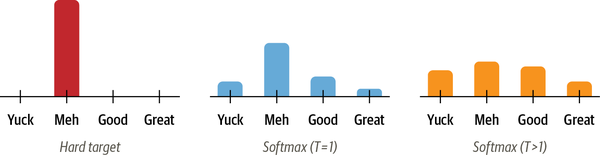

Since the student also produces softened probabilities qi(x) of its own, we can use the **Kullback–Leibler (KL)** divergence to measure the difference between the two probability distributions:


With the KL divergence we can calculate how much is lost when we approximate the probability distribution of the teacher with the student. This allows us to define a knowledge distillation loss:

For classification tasks, the student loss is then a weighted average of the distillation loss with the usual cross-entropy loss LCE of the ground truth labels:



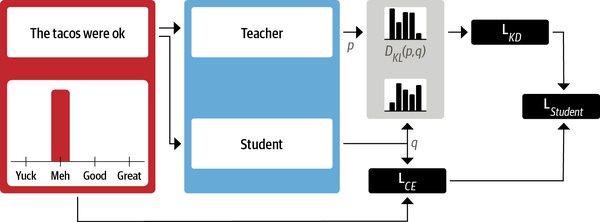

## Creating a Knowledge Distillation Trainer

To implement knowledge distillation we need to add a few things to the Trainer base class:

* The new hyperparameters α and T, which control the relative weight of the distillation loss (α) and how much the probability distribution of the labels should be smoothed (T)

* The fine-tuned teacher model, which in our case is BERT-base

* A new loss function that combines the cross-entropy loss with the knowledge distillation loss



In [36]:
# Adding the new hyperparameters is quite simple, 
# since we just need to subclass TrainingArguments and include them as new attributes:

from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [37]:
"""
For the trainer itself, we need a new loss function. 
The way to implement this is by subclassing Trainer and overriding the compute_loss() method.
"""

import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss # cross-entropy classic classifier problem
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(                        # using DistillationTrainingArguments  α and T
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

Let’s unpack this code a bit. When we instantiate DistillationTrainer we pass a teacher_model argument with a teacher that has already been fine-tuned on our task. 

Next, in the compute_loss() method we extract the logits from the student and teacher, scale them by the temperature, and then normalize them with a softmax before passing them to PyTorch’s nn.KLDivLoss() function for computing the KL divergence. 

One quirk with nn.KLDivLoss() is that it expects the inputs in the form of log probabilities and the labels as normal probabilities. That’s why we’ve used the F.log_softmax() function to normalize the student’s logits, while the teacher’s logits are converted to probabilities with a standard softmax. 

The reduction=batchmean argument in nn.KLDivLoss() specifies that we average the losses over the batch dimension.

## Choosing a Good Student Initialization

In our case study the teacher is BERT, so DistilBERT is a natural candidate to initialize the student with since it has 40% fewer parameters and has been shown to achieve strong results on downstream tasks.

In [12]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels") # renamed the intent column to labels so it can be automatically detected by the trainer

  0%|          | 0/6 [00:00<?, ?ba/s]

In [39]:
clinc_enc["test"][0]

{'labels': 61,
 'input_ids': [101, 2129, 2052, 2017, 2360, 4875, 1999, 3059, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [41]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [42]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, 
    evaluation_strategy = "epoch",
    num_train_epochs=5, 
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, 
    alpha=1,  # NOT USING TEACHER. (without any signal from the teacher)
    weight_decay=0.01,
    push_to_hub=True)

In [43]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [44]:
from transformers import AutoConfig
print(student_ckpt)
num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, 
                                             num_labels=num_labels,
                                             id2label=id2label, 
                                             label2id=label2id))



distilbert-base-uncased


In [45]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [46]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [47]:
distilbert_trainer = DistillationTrainer(
    
    model_init=student_init,
    teacher_model=teacher_model, 
    args=student_training_args,
    train_dataset=clinc_enc['train'], 
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, 
    tokenizer=student_tokenizer
    
    )


distilbert_trainer.train()

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Download file pytorch_model.bin:   0%|          | 15.4k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Download file runs/Jan16_10-06-28_ac8238843f17/events.out.tfevents.1673864203.ac8238843f17.1334.0: 100%|######…

Download file runs/Jan16_10-06-28_ac8238843f17/1673864203.6131372/events.out.tfevents.1673864203.ac8238843f17.…

Download file runs/Jan17_09-18-16_fda5da87abb8/1673947442.6980734/events.out.tfevents.1673947442.fda5da87abb8.…

Download file runs/Jan16_18-28-35_d207843ea3bc/1673893935.9443989/events.out.tfevents.1673893935.d207843ea3bc.…

Download file runs/Jan17_09-18-16_fda5da87abb8/events.out.tfevents.1673947442.fda5da87abb8.1067.0: 100%|######…

Clean file training_args.bin:  29%|##9       | 1.00k/3.43k [00:00<?, ?B/s]

Clean file runs/Jan16_10-06-28_ac8238843f17/events.out.tfevents.1673864203.ac8238843f17.1334.0:   7%|7        …

Clean file runs/Jan16_10-06-28_ac8238843f17/1673864203.6131372/events.out.tfevents.1673864203.ac8238843f17.133…

Clean file runs/Jan17_09-18-16_fda5da87abb8/1673947442.6980734/events.out.tfevents.1673947442.fda5da87abb8.106…

Clean file runs/Jan16_18-28-35_d207843ea3bc/1673893935.9443989/events.out.tfevents.1673893935.d207843ea3bc.409…

Clean file runs/Jan17_09-18-16_fda5da87abb8/events.out.tfevents.1673947442.fda5da87abb8.1067.0:   7%|7        …

Download file runs/Jan16_18-28-35_d207843ea3bc/events.out.tfevents.1673893935.d207843ea3bc.4091.0: 100%|######…

Clean file runs/Jan16_18-28-35_d207843ea3bc/events.out.tfevents.1673893935.d207843ea3bc.4091.0:   9%|8        …

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.288991,0.743226
2,3.786800,1.875629,0.837742
3,3.786800,1.157165,0.896129
4,1.692900,0.857340,0.913226
5,0.905800,0.772089,0.918387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=1590, training_loss=2.0514509908808103, metrics={'train_runtime': 361.273, 'train_samples_per_second': 211.059, 'train_steps_per_second': 4.401, 'total_flos': 413896353421488.0, 'train_loss': 2.0514509908808103, 'epoch': 5.0})

The 92% accuracy on the validation set looks quite good compared to the 94% that the BERT-base teacher achieves. Now that we’ve fine-tuned DistilBERT, let’s push the model to the Hub so we can reuse it later:

In [48]:
distilbert_trainer.push_to_hub("Training completed!")

Saving model checkpoint to distilbert-base-uncased-finetuned-clinc
Configuration saved in distilbert-base-uncased-finetuned-clinc/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json


Upload file runs/Feb20_09-09-39_3ea0f13d2010/events.out.tfevents.1676884286.3ea0f13d2010.297.0: 100%|#########…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/GV05/distilbert-base-uncased-finetuned-clinc
   a99bd5d..a47de5f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/GV05/distilbert-base-uncased-finetuned-clinc
   a99bd5d..a47de5f  main -> main

To https://huggingface.co/GV05/distilbert-base-uncased-finetuned-clinc
   a47de5f..1db1560  main -> main

   a47de5f..1db1560  main -> main



'https://huggingface.co/GV05/distilbert-base-uncased-finetuned-clinc/commit/a47de5f762bc6af82982bc0828ce22e9cee5d2b0'

In [ ]:
finetuned_ckpt = "GV05/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [50]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 44.13 +\- 9.04
Accuracy on test set - 0.862


In [51]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1508378982544,
  'time_avg_ms': 82.61263666998957,
  'time_std_ms': 16.36317076431462,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 44.1331145699769,
  'time_std_ms': 9.043259873180142,
  'accuracy': 0.8618181818181818}}

In [52]:
optim_type

'DistilBERT'

In [54]:
import pandas as pd
df = pd.DataFrame.from_dict(perf_metrics, orient='index')
df

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.150838,82.612637,16.363171,0.867273
DistilBERT,255.881436,44.133115,9.043260,0.861818


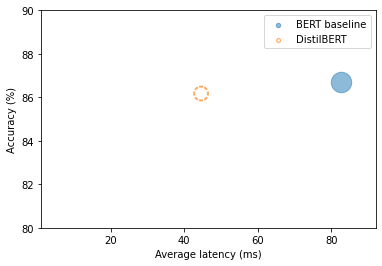

In [55]:
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 10)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

## Finding Good Hyperparameters with Optuna

In [56]:
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.9 MB/s eta 0:00:00


In [60]:
# In Optuna, we can find the minimum of f(x,y) by defining an objective() function that returns the value of f(x,y):
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2  # the minimum is x=1, y=1

In [ ]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

In [62]:
study.best_params

{'x': 0.990851563420203, 'y': 0.9862595308227347}

We see that with one thousand trials, Optuna has managed to find values for x and y that are reasonably close to the global minimum. To use Optuna in  Transformers, we use similar logic by first defining the hyperparameter space that we wish to optimize over. In addition to α and T, we’ll include the number of training epochs as follows:

In [63]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
            "alpha": trial.suggest_float("alpha", 0, 1),
            "temperature": trial.suggest_int("temperature", 2, 20)}

Running the hyperparameter search with the Trainer is then quite simple; we just need to specify the number of trials to run and a direction to optimize for. Because we want the best possible accuracy, we specify direction="maximize" in the hyper​para⁠meter_​search() method of the trainer and pass the hyperparameter search space as follows:

In [64]:
best_run = distilbert_trainer.hyperparameter_search(n_trials=5, direction="maximize", hp_space=hp_space) # was 20 for faster run change to 5 but its's still take houers!

[I 2023-02-20 09:35:12,499] A new study created in memory with name: no-name-e62f94aa-1586-4a57-820b-b2265e63038a
Trial: {'num_train_epochs': 9, 'alpha': 0.7059918967102063, 'temperature': 10}
loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.205725,0.605161
2,0.325300,0.098591,0.832903
3,0.325300,0.064370,0.887742
4,0.113300,0.048992,0.903871
5,0.071500,0.040416,0.911935
6,0.071500,0.035637,0.918710
7,0.056200,0.032764,0.919355
8,0.049200,0.031113,0.921935
9,0.049200,0.030536,0.922903


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.235130,0.623871
2,0.370800,0.106920,0.842903
3,0.370800,0.066606,0.890968
4,0.123400,0.049209,0.907419
5,0.074600,0.040198,0.917097
6,0.074600,0.035253,0.921613
7,0.057800,0.032324,0.921935
8,0.050300,0.030684,0.925484
9,0.050300,0.030104,0.926129


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203624,0.601290
2,0.322000,0.097955,0.832581
3,0.322000,0.064176,0.886452
4,0.112500,0.048943,0.903226
5,0.071300,0.040440,0.911290
6,0.071300,0.035677,0.918065
7,0.056100,0.032806,0.919032
8,0.049100,0.031160,0.921613
9,0.049100,0.030581,0.922581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.238586,0.618387
2,0.373400,0.111944,0.836452
3,0.373400,0.071693,0.887097
4,0.128700,0.054469,0.905161
5,0.081000,0.045848,0.911935
6,0.081000,0.041715,0.914516
7,0.065600,0.040238,0.915806


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197841,0.581613
2,0.310700,0.098862,0.820968
3,0.310700,0.067268,0.881935
4,0.113100,0.053077,0.897742
5,0.075100,0.045457,0.908387
6,0.075100,0.041732,0.910968
7,0.062100,0.040443,0.912258


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-100

The hyperparameter_search() method returns a BestRun object, which contains the value of the objective that was maximized (by default, the sum of all metrics) and the hyperparameters it used for that run:

In [65]:
print(best_run)

BestRun(run_id='1', objective=0.9261290322580645, hyperparameters={'num_train_epochs': 9, 'alpha': 0.3044128529439929, 'temperature': 5})


In [ ]:
# BestRun(run_id='10', objective=0.93, hyperparameters={'num_train_epochs': 10, 'alpha': 0.04567798196442968, 'temperature': 2})

This value of α tells us that most of the training signal is coming from the knowledge distillation term. Let’s update our training arguments with these values and run the final training run:

In [66]:
for k,v in best_run.hyperparameters.items():
    print(k,v)

num_train_epochs 9
alpha 0.3044128529439929
temperature 5


In [67]:
param_dict = {'num_train_epochs':9, 'alpha':0.3044128529439929, 'temperature':5}

In [68]:
# for k,v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)

for k,v in param_dict.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Download file pytorch_model.bin:   0%|          | 16.5k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Clean file training_args.bin:  29%|##9       | 1.00k/3.43k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.137072,0.758710
2,1.394200,0.598077,0.881290
3,1.394200,0.351851,0.921613
4,0.543700,0.250876,0.936774
5,0.265100,0.212440,0.941290
6,0.265100,0.194494,0.946774
7,0.187500,0.185328,0.947742
8,0.161000,0.181537,0.947419
9,0.161000,0.179972,0.947097


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-1000
Configuration saved in distilbert-

In [69]:
distil_trainer.push_to_hub("Training complete")

Saving model checkpoint to distilbert-base-uncased-distilled-clinc
Configuration saved in distilbert-base-uncased-distilled-clinc/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/GV05/distilbert-base-uncased-distilled-clinc
   d64e534..42220e1  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/GV05/distilbert-base-uncased-distilled-clinc
   d64e534..42220e1  main -> main

To https://huggingface.co/GV05/distilbert-base-uncased-distilled-clinc
   42220e1..208ad1a  main -> main

   42220e1..208ad1a  main -> main



'https://huggingface.co/GV05/distilbert-base-uncased-distilled-clinc/commit/42220e1932f1c4182acf935e3761b40d01b043c2'

In [ ]:
distilled_ckpt = "GV05/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)

In [71]:
optim_type = "distilbert Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 39.23 +\- 2.34
Accuracy on test set - 0.875


In [72]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1508378982544,
  'time_avg_ms': 82.61263666998957,
  'time_std_ms': 16.36317076431462,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 44.1331145699769,
  'time_std_ms': 9.043259873180142,
  'accuracy': 0.8618181818181818},
 'distilbert Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 39.234776129924285,
  'time_std_ms': 2.3431310098931166,
  'accuracy': 0.8745454545454545}}

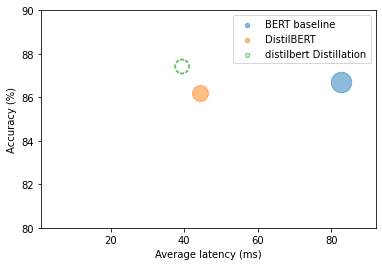

In [73]:
plot_metrics(perf_metrics, optim_type)

# Making Models Faster with Quantization
We’ve now seen that with knowledge distillation we can reduce the computational and memory cost of running inference by transferring the information from a teacher into a smaller student. 

Quantization takes a different approach; instead of reducing the number of computations, it makes them much more efficient by representing the weights and activations with **low-precision data types** like 8-bit integer (INT8) instead of the usual 32-bit floating point (FP32).

When we talk about using low-precision data types like 8-bit integer (INT8) or 16-bit floating point (FP16) in machine learning, we are referring to the bit-width used to represent numerical values but it does not affect the precision of the fractional part of a number.

Reducing the number of bits means the resulting model requires less memory storage, and operations like matrix multiplication can be performed much faster with integer arithmetic. 

Remarkably, these performance gains can be realized with little to no loss in accuracy!

In [ ]:
#Implementing dynamic quantization in PyTorch is quite simple and can be done with a single line of code:

from torch.quantization import quantize_dynamic

model_ckpt = "GV05/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

Here we pass to quantize_dynamic() the full-precision model and specify the set of PyTorch layer classes in that model that we want to quantize. 

The dtype argument specifies the target precision and can be fp16 or qint8. 

A good practice is to pick the lowest precision that you can tolerate with respect to your evaluation metrics. In this chapter we’ll use INT8, which as we’ll soon see has little impact on our model’s accuracy.

In [75]:
pipe = pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)
optim_type = "distilbert Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 16.29 +\- 1.54
Accuracy on test set - 0.878


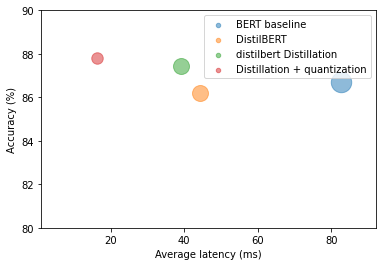

In [79]:
plot_metrics(perf_metrics, optim_type)

Question : quantization, it's the same as using fp16 Half-precision floating-point format?

CHAT GPT ANSWER:

Quantization and half-precision floating-point format (FP16) are two different techniques for reducing the memory and computation requirements of neural networks.

Quantization involves reducing the precision of the network's weights and activations from 32-bit floating point (FP32) to lower precision formats such as 8-bit integers (INT8) or 16-bit floating point (FP16). This reduces the memory required to store the network's parameters and activations, and can also lead to faster computation on specialized hardware that is optimized for low-precision arithmetic.

Quantization involves more than just replacing the format of weights and activations in a neural network. It typically involves using smart algorithms to minimize the loss of accuracy that can result from reducing the precision of the network's parameters and activations.

On the other hand, half-precision floating-point format (FP16) is a specific format for representing floating-point numbers that uses 16 bits instead of the 32 bits used by the more common single-precision format (FP32). FP16 can also reduce memory usage and improve computation speed on some hardware platforms, but it does not involve quantization of weights and activations.

While both techniques can lead to performance improvements, they have different trade-offs and can be used in different contexts. Quantization can be particularly effective for reducing memory usage and improving computation speed on hardware platforms that support low-precision arithmetic, while FP16 can be useful for reducing memory usage and improving computation speed on general-purpose processors or GPUs.

# Optimizing Inference with ONNX and the ONNX Runtime

ONNX is an open standard that defines a common set of operators and a common file format to represent deep learning models in a wide variety of frameworks, including PyTorch and TensorFlow.

For example, a model trained in PyTorch can be exported to ONNX format and then imported in TensorFlow (and vice versa).

Where ONNX really shines is when it is coupled with a dedicated accelerator like ONNX Runtime, or ORT for short.

To see ORT in action, the first thing we need to do is convert our distilled model into the ONNX format. 

The  Transformers library has a built-in function called **con⁠vert_graph_to_onnx.convert()** that simplifies the process by taking the following steps:

* Initialize the model as a Pipeline.

* Run placeholder inputs through the pipeline so that ONNX can record the computational graph.

* Define dynamic axes to handle dynamic sequence lengths.

* Save the graph with network parameters.

In [13]:
#To use con⁠vert_graph_to_onnx.convert(), we first need to set some OpenMP environment variables for ONNX:

import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
f"{cpu_count()}"

'2'

**OpenMP** is an API designed for developing highly parallelized applications.

The **OMP_NUM_THREADS** environment variable sets the number of threads to use for parallel computations in the ONNX Runtime, while **OMP_WAIT_POLICY**=ACTIVE specifies that waiting threads should be active (i.e., using CPU processor cycles).

In [ ]:
# convert our distilled model to the ONNX format

from transformers.convert_graph_to_onnx import convert

model_ckpt = "GV05/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

convert(framework="pt", 
        model=model_ckpt, 
        tokenizer=tokenizer,
        output=onnx_model_path, 
        opset=12,    # ONNX uses operator sets to group together immutable operator specifications, so opset=12 corresponds to a specific version of the ONNX library.
        pipeline_name="text-classification", # convert() wraps the model in a  Transformers pipeline() function during the conversion.
        )

In [84]:
# !pip install -U onnx
# !pip -q install onnxruntime

In [14]:
# Now that we have our model saved, we need to create an InferenceSession instance to feed inputs to the model:

from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): # provider is the name of the execution provider to use (default is "CPUExecutionProvider").
    options = SessionOptions()                                              # creates a SessionOptions object to configure the session options
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL  # This enables all available optimizations for the ONNX graph, including memory optimization and graph transformation.
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [16]:
onnx_model = create_model_for_provider(onnx_model_path)

Now when we call onnx_model.run(), we can get the class logits from the ONNX model. 

Let’s test this out with an example from the test set. 

Since the output from convert() tells us that ONNX expects just the input_ids and attention_mask as inputs ("Generated inputs order: ['input_ids', 'attention_mask']"), we need to drop the label column from our sample.

In [17]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
inputs

{'input_ids': [[101, 2129, 2052, 2017, 2360, 4875, 1999, 3059, 102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [18]:
"""
the onnx_model.run() method is called with the outputs parameter set to None, indicating that all outputs from the ONNX graph should be returned, 
and the feed_dict parameter set to the input data in the inputs dictionary.
"""
logits_onnx = onnx_model.run(None, inputs)[0] 
logits_onnx.shape

(1, 151)

In [19]:
len(onnx_model.run(None, inputs))

1

In [20]:
np.argmax(logits_onnx), clinc_enc["test"][0]["labels"]

(61, 61)

In [21]:
# The ONNX model is not compatible with the text-classification pipeline, so we’ll create our own class that mimics the core behavior:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [29]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.86356056}]

In [30]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [102]:
optim_type = "distilbert Distillation + ONNX"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 25.84 +\- 1.46
Accuracy on test set - 0.875


In [35]:
pd.DataFrame(perf_metrics).T

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.150838,82.612637,16.363171,0.867273
DistilBERT,255.881436,44.133115,9.043260,0.861818
distilbert Distillation,255.881436,39.234776,2.343131,0.874545
distilbert Distillation + quantization,132.390729,16.292972,1.536820,0.878182
distilbert Distillation + ONNX,255.979470,25.835238,1.457675,0.874545


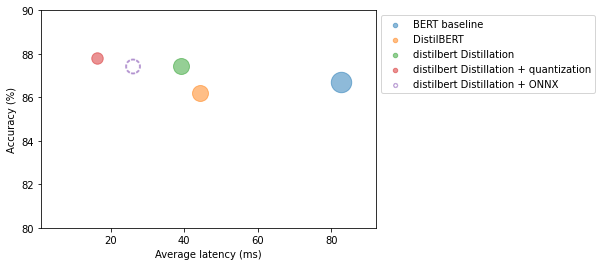

In [38]:
plot_metrics(perf_metrics, optim_type)

Similar to PyTorch, ORT offers three ways to quantize a model: dynamic, static, and quantization-aware training. 

As we did with PyTorch, we’ll apply dynamic quantization to our distilled model. 

In ORT, the quantization is applied through the **quan⁠tize_dynamic()** function, which requires:
* a path to the ONNX model to quantize, 
* a target path to save the quantized model to 
* the data type to reduce the weights to:

In [39]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

The messages "Ignore MatMul due to non constant B" indicate that the quantization process is not being applied to certain layers in your model, specifically the ones involving matrix multiplication (MatMul) operations.

This is because these operations have non-constant bias (B) terms, which means that the quantization algorithm cannot directly convert them to int8 format. Instead, the algorithm will keep these layers in the original floating-point format.

In general, it is normal to see some layers being excluded from the quantization process, especially if they involve non-constant parameters or operations that are difficult to quantize accurately.

In [40]:
model_output

'onnx/model.quant.onnx'

In [41]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "distilbert Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.31
Average latency (ms) - 16.68 +\- 2.79
Accuracy on test set - 0.882


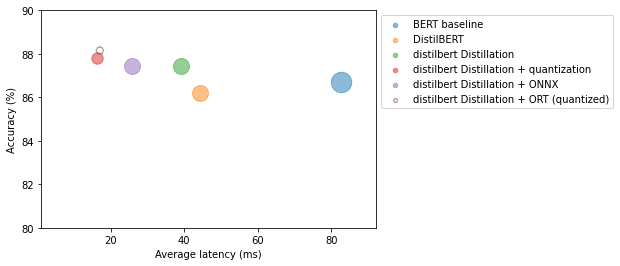

In [42]:
plot_metrics(perf_metrics, optim_type)

In [43]:
pd.DataFrame(perf_metrics).T

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.150838,82.612637,16.363171,0.867273
DistilBERT,255.881436,44.133115,9.043260,0.861818
distilbert Distillation,255.881436,39.234776,2.343131,0.874545
distilbert Distillation + quantization,132.390729,16.292972,1.536820,0.878182
distilbert Distillation + ONNX,255.979470,25.835238,1.457675,0.874545
distilbert Distillation + ORT (quantized),64.305834,16.681866,2.785797,0.881818


# Making Models Sparser with Weight Pruning

So far we’ve seen that knowledge distillation and weight quantization are quite effective at producing faster models for inference, **but in some cases you might also have strong constraints on the memory footprint of your model**.

shrink the number of parameters in our model by identifying and removing the least important weights in the network.

the main idea behind pruning is to gradually remove weight connections (and potentially neurons) during training such that the model becomes progressively sparser. The resulting pruned model has a smaller number of nonzero parameters, which can then be stored in a compact sparse matrix format. Pruning can be also combined with quantization to obtain further compression.

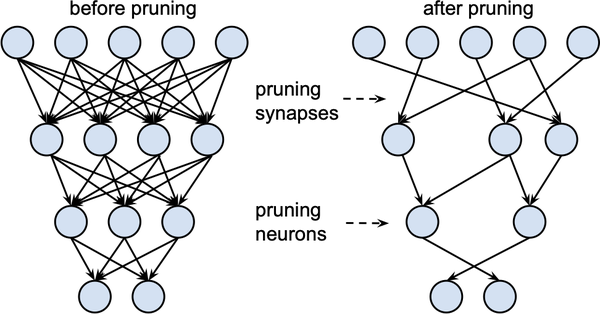

**Weight Pruning Methods**

Mathematically, the way most weight pruning methods work is to calculate a matrix 𝐒 of importance scores and then select the top k percent of weights by importance

at the heart of each pruning method are a set of questions that need to be considered:

* Which weights should be eliminated?

* How should the remaining weights be adjusted for best performance?

* How can such network pruning be done in a computationally efficient way?



As of this book’s writing,  Transformers does not support pruning methods out of the box. 

Fortunately, there is a nifty library called Neural Networks Block Movement Pruning that implements many of these ideas, and we recommend checking it out if memory constraints are a concern.